# **Micrograd Notebook**

## **1) Setting Up the 'value' class**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Creating the Class 'value' in which I define how the value is managed
class value:
    def __init__(self, data, _children=(), _op = ''):
        self.data = data
        self.grad = 0.0 # Where this value is the derivative of this current value (node) with respect to the final one
        self._prev = set(_children)
        self._op = _op
    def __repr__(self):
        return f"value(data={self.data}, op={self._op})"
    def __add__(self, other):
        out = value(self.data + other.data, (self, other), '+')
        return out
    def __mul__(self, other):
        out = value(self.data * other.data, (self, other), '*')
        return out
    def  tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        return value(t, (self, ), 'tanh')

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='png', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## **2) Building the Mathematical Expression**

In [4]:
# Here I'm building the expression --> L = [(a*b) + c] * f
a = value(2.0)
b = value(-3.0)
e = a * b # setting e = (a * b)

c = value(10)
d = e + c

f = value(-2.0)
L = d * f

L

value(data=-8.0, op=*)

## **3) Running Now Manual BackPropagation**
Backprop means that for each node, computing the derivative of that value by the output value
- In the following cell by adjusting where the (+h) is put you can mechanically compute the gradient of the result L with respect to the node-i (dL/di)

In [5]:
def lol():
    
    h = 0.0001
    
    a = value(2.0)
    b = value(-3.0)
    e = a * b # setting e = (a * b)
    c = value(10)
    d = e + c
    f = value(-2.0)
    L = d * f
    L1 = L.data

    a = value(2.0)
    b = value(-3.0)
    e = a * b # setting e = (a * b)
    c = value(10)
    d = e + c
    d.data += h
    f = value(-2.0)
    L = d * f
    L2 = L.data
    
    print('derivative of L with respect to "a" is:', (L2-L1)/h)
    
lol()

derivative of L with respect to "a" is: -1.9999999999953388


## **4) Using Now the tanh Activation Function**
- Here we are considering the functioning of a single neuron

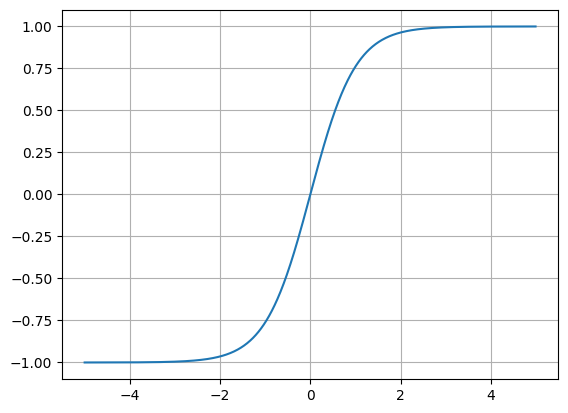

In [6]:
plt.plot(np.arange(-5, 5, 0.01), np.tanh(np.arange(-5, 5, 0.01)))
plt.grid()

In [7]:
# inputs x1, x2
x1 = value(2.0)
x2 = value(0.0)

# weights w1, w2
w1 = value(-3.0)
w2 = value(1.0)

# bias of the neuron
b = value(6.8813735870195432) # strange number to get good values

# Step 1 (where the variables (xs) are weighted through the ws)
x1w1 = x1*w1
x2w2 = x2*w2

# Step 2 (where there is the sum of the two weighted inputs)
x1w1x2w2 = x1w1+x2w2

# Step 3 (computation of the activation function)
n = x1w1x2w2 + b
o = n.tanh()

- The idea is that now with back propagation we can change the weights (not the inputs) through the gradient

In [8]:
# do/dn = d(tanh(x))/dx = 1 - tanh(x)**2
o.grad = 1.0
n.grad = 1 - o.data**2

x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = b.grad
x2w2.grad = b.grad

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

## **5) Redefining the Class with BackProp Now**

In [9]:
# Creating the Class 'value' in which I define how the value is managed
class value:
      
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out

In [10]:
# inputs x1, x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')

# weights w1, w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')

# bias of the neuron
b = value(6.8813735870195432, label='b') # strange number to get good values

# Step 1 (where the variables (xs) are weighted through the ws)
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2

# Step 2 (where there is the sum of the two weighted inputs)
x1w1x2w2 = x1w1+x2w2; x2w2.label = 'x2w2'

# Step 3 (computation of the activation function)
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [11]:
o.grad = 1.0
print(o.grad)
o._backward()

1.0


In [12]:
print(n.grad)
n._backward()

0.4999999999999999


In [13]:
print(x1w1x2w2.grad)
x1w1x2w2._backward()

0.4999999999999999


In [14]:
print(x1w1.grad)
print(x2w2.grad)
x1w1._backward()
x2w2._backward()

0.4999999999999999
0.4999999999999999


In [15]:
print(x1.grad)
print(w1.grad)

-1.4999999999999996
0.9999999999999998


In [16]:
print(x2.grad)
print(w2.grad)

0.4999999999999999
0.0


## **Now instead of Running it by hand, we do it with reverse order of Computation**

In [17]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

## **Showing Similarity of Micrograd with PyTorch**

In [18]:
import torch
import random

In [19]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## **Creating the Classes that then create the Neural Network**

In [38]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x